# Baseball Analysis
Analysis on baseball data.

### Data Sources
1. [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/)
    - [GitHub CSV Version](https://github.com/chadwickbureau/baseballdatabank)

### Questions
1. Regression -> Relationship between salary and team, appearances, and awards.
1. Visualization -> Salary by Position over Time
1. ...

In [79]:
import os
import re
import json
from datetime import datetime
from math import ceil
from io import StringIO
# quant analysis
import sqlite3
import numpy as np
import pandas as pd
# import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats
# data viz
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
def CONFIG():
    """"""
    pid = 'analysis-baseball'
    now = datetime.now()
    cwd = os.getcwd()
    data = os.path.join(cwd,'data')
    
    cfg = {
        'data': data,
        'lahman': os.path.join(data, 'lahmansbaseballdb.sqlite'),
        'eda': {
            'path': os.path.join(cwd,'eda'),
            'key': '{table_name}.md'
        },
        'viz': os.path.join(cwd,'viz')
    }
    
    return cfg

In [41]:
def EDA(df,f_out,n=10):
    """"""    
    name = os.path.basename(f_out).split('.')[0]
    lb = '\n'
    lblb = '\n\n'
    
    # columns & types
    content = '# EDA - {} Files {}'.format(os.path.basename(name).upper(),lblb)
    content+='#### Column Name [IDX] -  Dtype (Head / Tail) {}'.format(lb)
    dtypes = df.dtypes.to_dict()
    head = df.head(1).T.iloc[:,0].to_list() # to_dict() - head.get(j)
    tail = df.tail(1).T.iloc[:,0].to_list() # to_dict() - tail.get(j)
    for i,j in enumerate(df.columns):
        content+='- **{}** [{}] - {} ({} / {}) {}'.format(j, i, dtypes.get(j), head[i], tail[i], lb)
    
    # html
    content+='{}#### Head / Tail [n={}] Sample {}'.format(lb+lblb,n,lblb)
    content+=(df.head(n).append(df.tail(n)).to_html(None,index=False,header=True))
    
    with open(f_out,'w') as f:
        f.write(content)

In [ ]:
def SQLITE_TABLES(cnxn):
    """"""
    cur = cnxn.cursor()
    for i in cur.execute("select name from sqlite_master where type = 'table'").fetchall():
        yield i[0]

In [125]:
def SALARY_SQL():
    """"""
    query = """
        with
            cte_awards as (
                select distinct
                    yearid,playerid,count(*) as awards_count
                from awardsplayers
                group by 1,2
            )
        select distinct
            a.yearid, a.teamid
            ,a.playerid, a.salary
            ,coalesce(b.awards_count,0) as awards_count
            --,strftime('%Y', f.debut_date) as debut_year
            ,(a.yearid - strftime('%Y', f.debut_date)) as years_in_league
            ,(cast(d.h as float)/cast(d.ab as float)) as batting_avg
            ,e.pos as position
            ,c.G_all, c.GS
            ,c.G_batting
            ,c.G_defense
            --,c.G_p, c.G_c
            --,c.G_1b, c.G_2b
            --,c.G_3b, c.G_ss
            --,c.G_lf, c.G_cf
            --,c.G_rf, c.G_of
            --,c.G_dh, c.G_ph
            --,c.G_pr
        from salaries as a
        left join cte_awards as b
            on a.playerid=b.playerid
            and a.yearid=(b.yearid-1)
        inner join appearances as c
            on a.playerid=c.playerid
            and a.yearid=(c.yearid-1)
            --and a.teamid=c.teamid
        inner join batting as d
            on a.playerid=d.playerid
            and a.yearid=(d.yearid-1)
            --and a.teamid=d.teamid
        inner join fielding as e
            on a.playerid=e.playerid
            and a.yearid=(e.yearid-1)
            --and a.teamid=e.teamid
        inner join people as f
            on a.playerid=f.playerid
        where a.yearid>=2000
        ;
    """
    
    return query

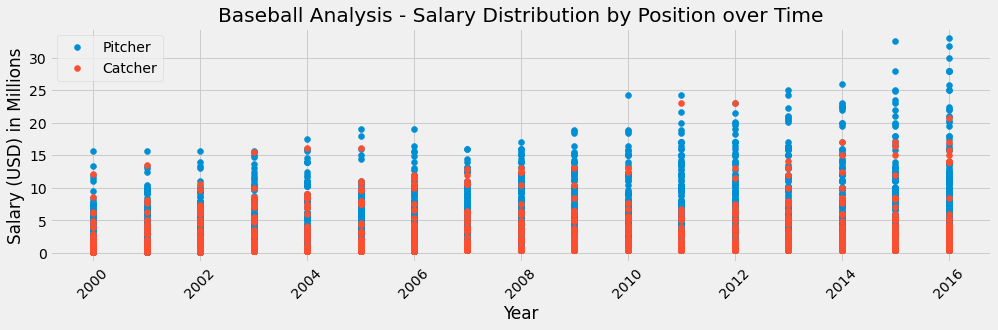

In [135]:
if __name__=='__main__':
    CFG = CONFIG()
    
    # eda
    eda = False
    if eda:
        with sqlite3.connect(CFG['lahman']) as cnxn:
            for table in SQLITE_TABLES(cnxn):
                query_base = 'select * from {table_name}' # "pragma table_info('{table_name}')" # -> sqlite metadata
                df = pd.read_sql(query_base.format(table_name=table), cnxn)
                EDA(df, os.path.join(CFG['eda']['path'],CFG['eda']['key'].format(table_name=table)))
    # salary - regression & plotting
    with sqlite3.connect(CFG['lahman']) as cnxn:
        query = SALARY_SQL()
        df = pd.read_sql(query, cnxn)
        df.columns = map(lambda x: x.lower(), df.columns)
#     for i in df.columns:
#         print(f'{i}: {df.loc[1:5,i].to_list()}')
    regression = False
    if regression:
        # params
        year = 2016
        y_var = 'salary'
        x_cat = ['teamid','position']
        x_vars = [
            'awards_count','years_in_league'
            ,'batting_avg','gs'
            ,'g_batting','g_defense'
        ] + x_cat
        df_clean = df.loc[df.yearid==year].fillna(value=0)
        # data
        x = pd.get_dummies(
            df_clean.loc[:,x_vars]
            # .dropna().drop(x_drop, axis=1)
            ,prefix='cat', prefix_sep='_'
            ,columns=x_cat, drop_first=True
        )
        y = df_clean.loc[:,y_var]
        # model
        lm = linear_model.LinearRegression()
        model = lm.fit(x,y)
        model.score(x,y)
    
    graph = True
    if graph:
        ### cfg ###
        df['salary_mil'] = df['salary']/1000000
        cols = ('yearid','salary_mil')
        pos1 = ('P','Pitcher')
        pos2 = ('C','Catcher')
        ### init ###
        fig, ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=(14,4)) # __ -> (ax1,ax2)
        ### labels, formatting ###
        plt.grid(True)
        plt.tight_layout()
        plt.style.use('fivethirtyeight') # ggplot, seaborn, fivethirtyeight, tableau-colorblind10, grayscale
        #plt.xticks(ticks=x_indexes,labels=ages_x)
        plt.xticks(rotation=45)
        ### axis ###
        ax.set_xlabel('Year')
        ax.set_ylabel('Salary (USD) in Millions')
        ax.set_title('Baseball Analysis - Salary Distribution by Position over Time')
        ### plot ###
        ax.scatter(
            x=df.loc[df.position==pos1[0],cols[0]],
            y=df.loc[df.position==pos1[0],cols[1]],
            label=pos1[1]
        )
        ax.scatter(
            x=df.loc[df.position==pos2[0],cols[0]],
            y=df.loc[df.position==pos2[0],cols[1]],
            label=pos2[1]
        )
        ax.legend()
        fig.savefig(os.path.join(CFG['viz'],'salary_by_pos.svg'))